In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from theano import shared

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
%config Inline.figure_format = 'retina'
# az.style.use('arviz-whitegrid')
az.rcParams['stats.credible_interval'] = 0.89
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['legend.fontsize']=10
plt.rcParams['axes.labelsize']=12
plt.rcParams['axes.titlesize']=12
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['figure.titlesize']=15
np.random.seed(0)

#### 5H1.
**Q**: In the divorce example, suppose the DAG is : M -> A -> D. hat are the implied conditional indepedences of the graph? Are the data consistent with it?  

**A**: Given marriage rate, median marriage age is independent of divorce rate. Or alternative speaking, knowing marriage rate, median marriage age gives no additional information about divorce rate. 

Data are not consistent with this DAG. The 89% HPD of M contains 0. When conditioned on M, if DAG is correct, I should expect to see A has little influences on D. This is not the case, as demostrated by the counterfactual plot. Well, no surprises there judging from the coefs in az.summary. 

In [3]:
data = pd.read_csv(os.path.join("/Users/huishi/Learning_DS/pymc3_resources/Rethinking_2/Data", "WaffleDivorce.csv"), delimiter=";")

In [4]:
def standardize(s, baseline=None):
    """Standardize a pandas series/numpy array"""
    if baseline is None:
        return (s - s.mean())/s.std()
    else:
        return (s - baseline.mean())/baseline.std()

In [5]:
def unstandadize(s, baseline):
    """Unstandardize a pandas series/numpy array"""
    return (s * baseline.std()) + baseline.mean()

In [5]:
data = (data
       .assign(
           medage_std = standardize(data.MedianAgeMarriage),
           divorce_rate_std = standardize(data.Divorce),
           marriage_rate_std = standardize(data.Marriage))
       )

In [6]:
with pm.Model() as m1:
    # data
    age_std = pm.Data("age_std", data.medage_std)
    mar_std = pm.Data("mar_std", data.marriage_rate_std)
    div_std = pm.Data('div_std', data.divorce_rate_std)
    
    # prior
    a = pm.Normal('a', mu=0, sigma=0.2)
    bM = pm.Normal('bM', mu=0, sigma=0.5)
    bA = pm.Normal('bA', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    # regression + likelihood
    mu = pm.Deterministic("mu", a + bM * mar_std + bA * age_std)
    pred_div_std = pm.Normal('pred_div_std', mu=mu, sigma=sigma, observed=div_std)
    
    # samples
    trace_m1 = pm.sample() 
    ppc_m1 = pm.sample_posterior_predictive(trace_m1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a]
100%|██████████| 2000/2000 [00:17<00:00, 116.89it/s]


In [7]:
az.summary(trace_m1, kind='stats', var_names=["~mu"])

,mean,sd,hpd_5.5%,hpd_94.5%
a,-0.004,0.100,-0.164,0.151
bM,-0.062,0.153,-0.315,0.171
bA,-0.612,0.156,-0.849,-0.355
sigma,0.826,0.085,0.681,0.945


In [8]:
n = 30
age_seq_std = np.linspace(-3, 3, n)
with m1:
    pm.set_data({"mar_std": np.zeros(n), 
                  "age_std": age_seq_std})
    ppc_m1_cf = pm.sample_posterior_predictive(trace_m1, var_names=["mu", "pred_div_std"])

100%|██████████| 2000/2000 [00:19<00:00, 102.45it/s]


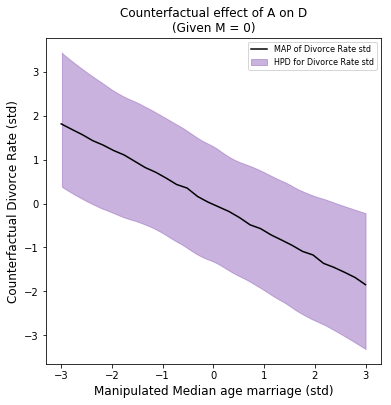

In [11]:
_, ax1 = plt.subplots(1, 1, figsize=(6,6))

# counterfactual effect A on D
ax1.plot(age_seq_std, ppc_m1_cf['pred_div_std'].mean(0), 'k', label=r"MAP of Divorce Rate std")
az.plot_hpd(age_seq_std, ppc_m1_cf['pred_div_std'], ax=ax1, color='C4',
           fill_kwargs={"alpha":0.5, "label":r"HPD for Divorce Rate std"})
ax1.set_xlabel("Manipulated Median age marriage (std)")
ax1.set_ylabel("Counterfactual Divorce Rate (std)")
ax1.set_title("Counterfactual effect of A on D\n(Given M = 0)")
ax1.legend(fontsize=8)
ax1.grid(False)

#### 5H2.
**Q**:Assuming that the DAG for the divorce example is indeed M -> A -> D, fit a new model and use it to estimate the counterfactual effect of havling a State's marriage rate M. 

**A: not sure which age values to pass to mu for divorce rate. Should I use `age_std` or `pred_age_std`? The two approaches yield very similar results.**

In cases where mar_std is not a good predictor of age_std, then the two approaches wont get similar results any more. 

When halving marriage rate and all else kept equal, divorce rate is expected to drop relatively by 20.4%.

##### 1. Use `age_std`

In [154]:
with pm.Model() as m2:
    # data
    age_std = pm.Data("age_std", data.medage_std)
    mar_std = pm.Data("mar_std", data.marriage_rate_std)
    div_std = pm.Data('div_std', data.divorce_rate_std)
    
    ## M -> A
    # prior for age
    a_age = pm.Normal('a_age', mu=0, sigma=0.2)
    bM_age = pm.Normal('bM_age', mu=0, sigma=0.5)
    sigma_age = pm.Exponential("sigma_age", lam=1)
    
    # regression for age
    mu_age = pm.Deterministic("mu_age", a_age + bM_age * mar_std)
    pred_age_std = pm.Normal("pred_age_std", mu=mu_age, sigma=sigma_age, observed=age_std)
    
    ## A -> D
    # prior for div
    a_div = pm.Normal('a_div', mu=0, sigma=0.2)
    bA_div = pm.Normal('bA_div', mu=0, sigma=0.5)
    sigma_div = pm.Exponential('sigma_div', lam=1)
    
    # regression + likelihood for div
    mu_div = pm.Deterministic("mu_div", a_div + bA_div * age_std)  # age_std or pred_age_std here?
    pred_div_std = pm.Normal('pred_div_std', mu=mu_div, sigma=sigma_div, observed=div_std)
          
    # samples
    trace_m2 = pm.sample() 
    ppc_m2 = pm.sample_posterior_predictive(trace_m2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_div, bA_div, a_div, sigma_age, bM_age, a_age]
100%|██████████| 2000/2000 [00:36<00:00, 55.46it/s]


In [155]:
az.summary(trace_m2, kind='stats', var_names=["~mu_age", "~mu_div"])

,mean,sd,hpd_5.5%,hpd_94.5%
a_age,-0.001,0.086,-0.135,0.137
bM_age,-0.695,0.098,-0.842,-0.534
a_div,-0.002,0.103,-0.166,0.163
bA_div,-0.567,0.113,-0.765,-0.408
sigma_age,0.710,0.072,0.598,0.815
sigma_div,0.822,0.083,0.693,0.952


##### With marriage rate from source data

In [263]:
with m2:
    pm.set_data({"mar_std": data.marriage_rate_std/2})
    ppc_m2["cf_age_std"] = pm.sample_posterior_predictive(trace_m2, var_names=['pred_age_std'])["pred_age_std"]

with m2:
    pm.set_data({"age_std": ppc_m2['cf_age_std'].mean(0)})
    ppc_m2["cf_div_std"] = pm.sample_posterior_predictive(trace_m2, var_names=["pred_div_std"])['pred_div_std']

100%|██████████| 2000/2000 [00:18<00:00, 108.63it/s]


Text(0.5, 1.0, 'Counterfactual of Halving Marriage Rate (std)\non Divorce Rate (std)')

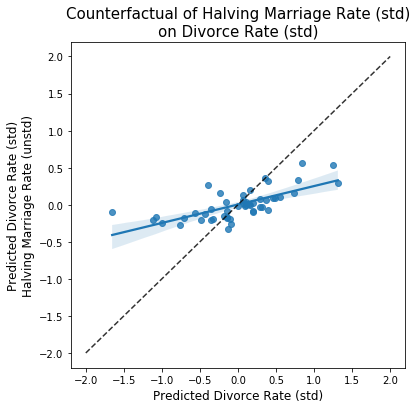

In [310]:
plt.figure(figsize=(6,6))
# plt.scatter(ppc_m2['pred_div_std'].mean(0), ppc_m2["cf_div_std"].mean(0))
sns.regplot(ppc_m2['pred_div_std'].mean(0), ppc_m2["cf_div_std"].mean(0))
plt.plot([-2, 2], [-2,2], 'k--', alpha=0.8)
plt.xlabel("Predicted Divorce Rate (std)")
plt.ylabel("Predicted Divorce Rate (std)\nHalving Marriage Rate (unstd)")
plt.title("Counterfactual of Halving Marriage Rate (std)\non Divorce Rate (std)", fontsize=15)

Text(0.5, 1.0, 'Counterfactual of Halving Marriage Rate (std)\non Median Marriage Age (std)')

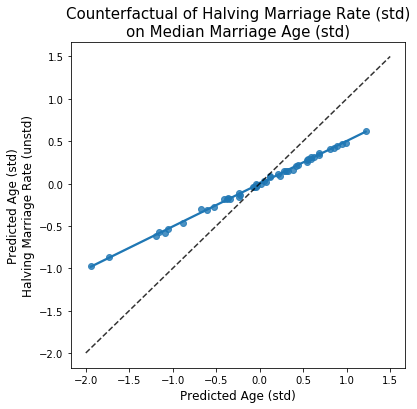

In [309]:
plt.figure(figsize=(6,6))
# plt.scatter(ppc_m2['pred_age_std'].mean(0), ppc_m2["cf_age_std"].mean(0))
sns.regplot(ppc_m2['pred_age_std'].mean(0), ppc_m2["cf_age_std"].mean(0))
plt.plot([-2,1.5], [-2,1.5], 'k--', alpha=0.8)
plt.xlabel("Predicted Age (std)")
plt.ylabel("Predicted Age (std)\nHalving Marriage Rate (unstd)")
plt.title("Counterfactual of Halving Marriage Rate (std)\non Median Marriage Age (std)", fontsize=15)

In [270]:
avg_orig_div = np.mean(ppc_m2['pred_div_std'].mean(0) * data.Divorce.std() + data.Divorce.mean())
avg_cf_div = np.mean(ppc_m2['cf_div_std'].mean(0) * data.Divorce.std() + data.Divorce.mean())

In [271]:
print(f"Avg divorce rate in samples is {avg_orig_div:.1f}%; If halving marriage rate, avg counterfactual divorce rate is {avg_cf_div:.1f}%")

Avg divorce rate in samples is 9.7%; If halving marriage rate, avg counterfactual divorce rate is 9.7%


##### With a new sequence of marriage rate 

In [272]:
n = 50
mar_seq = (np.linspace(data.Marriage.min(), data.Marriage.max(), n) - data.Marriage.mean()) / data.Marriage.std()
mar_seq_by_half = (np.linspace(data.Marriage.min()/2, data.Marriage.max()/2, n) - data.Marriage.mean()) / data.Marriage.std()

with m2:
    # origial marriage rate 
    pm.set_data({"mar_std": mar_seq})
    ppc_m2_cf = pm.sample_posterior_predictive(trace_m2, var_names=["pred_age_std"])
    pm.set_data({"age_std": ppc_m2_cf['pred_age_std'].mean(0)})
    ppc_m2_cf["pred_div_std"] = pm.sample_posterior_predictive(trace_m2, var_names=["pred_div_std"])['pred_div_std']
    
    # halving marriage rate 
    pm.set_data({"mar_std": mar_seq_by_half})
    ppc_m2_cf_by_half = pm.sample_posterior_predictive(trace_m2, var_names=["pred_age_std"])
    pm.set_data({"age_std": ppc_m2_cf_by_half['pred_age_std'].mean(0)})
    ppc_m2_cf_by_half["pred_div_std"] = pm.sample_posterior_predictive(trace_m2, var_names=["pred_div_std"])['pred_div_std']

100%|██████████| 2000/2000 [00:17<00:00, 112.54it/s]


Text(0.5, 1.0, 'Counterfactual of Halving Marriage Rate (unstd)\non Divorce Rate (unstd)')

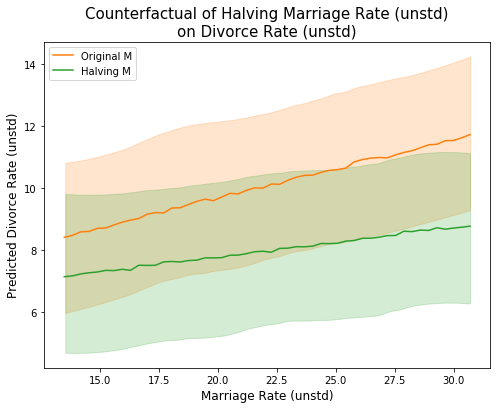

In [273]:
x_labels = mar_seq * data.Marriage.std() + data.Marriage.mean()
unscale_divorce_rate = lambda x: unstandadize(x, data.Divorce)

plt.figure(figsize=(8,6))
plt.plot(x_labels, unscale_divorce_rate(ppc_m2_cf['pred_div_std'].mean(0)), label="Original M", color='C1')
plt.plot(x_labels, unscale_divorce_rate(ppc_m2_cf_by_half["pred_div_std"].mean(0)), label="Halving M", color='C2')
az.plot_hpd(x_labels, unscale_divorce_rate(ppc_m2_cf['pred_div_std']), color='C1', fill_kwargs={"alpha": 0.2})
az.plot_hpd(x_labels, unscale_divorce_rate(ppc_m2_cf_by_half['pred_div_std']), color='C2', fill_kwargs={"alpha": 0.2})
plt.legend(fontsize=10)
plt.xlabel("Marriage Rate (unstd)")
plt.ylabel("Predicted Divorce Rate (unstd)")
plt.title("Counterfactual of Halving Marriage Rate (unstd)\non Divorce Rate (unstd)", fontsize=15)

Text(0.5, 1.0, 'Counterfactual of Halving Marriage Rate (unstd)\non Median Age(unstd)')

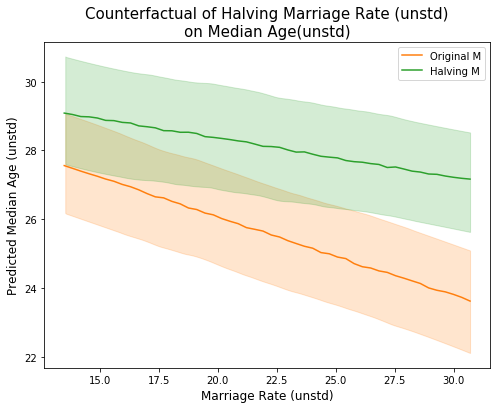

In [274]:
x_labels = mar_seq * data.Marriage.std() + data.Marriage.mean()
unscale_age = lambda x: unstandadize(x, data.MedianAgeMarriage)

plt.figure(figsize=(8,6))
plt.plot(x_labels, unscale_age(ppc_m2_cf['pred_age_std'].mean(0)), label="Original M", color='C1')
plt.plot(x_labels, unscale_age(ppc_m2_cf_by_half["pred_age_std"].mean(0)), label="Halving M", color='C2')
az.plot_hpd(x_labels, unscale_age(ppc_m2_cf['pred_age_std']), color='C1', fill_kwargs={"alpha": 0.2})
az.plot_hpd(x_labels, unscale_age(ppc_m2_cf_by_half['pred_age_std']), color='C2', fill_kwargs={"alpha": 0.2})
plt.legend(fontsize=10)
plt.xlabel("Marriage Rate (unstd)")
plt.ylabel("Predicted Median Age (unstd)")
plt.title("Counterfactual of Halving Marriage Rate (unstd)\non Median Age(unstd)", fontsize=15)

##### 2. Use `age_std_pred`

In [194]:
with pm.Model() as m2_2:
    # data
    age_std = pm.Data("age_std", data.medage_std)
    mar_std = pm.Data("mar_std", data.marriage_rate_std)
    div_std = pm.Data('div_std', data.divorce_rate_std)
    
    ## M -> A
    # prior for age
    a_age = pm.Normal('a_age', mu=0, sigma=0.2)
    bM_age = pm.Normal('bM_age', mu=0, sigma=0.5)
    sigma_age = pm.Exponential("sigma_age", lam=1)
    
    # regression for age
    mu_age = pm.Deterministic("mu_age", a_age + bM_age * mar_std)
    pred_age_std = pm.Normal("pred_age_std", mu=mu_age, sigma=sigma_age, observed=age_std)
    
    ## A -> D
    # prior for div
    a_div = pm.Normal('a_div', mu=0, sigma=0.2)
    bA_div = pm.Normal('bA_div', mu=0, sigma=0.5)
    sigma_div = pm.Exponential('sigma_div', lam=1)
    
    # regression + likelihood for div
    mu_div = pm.Deterministic("mu_div", a_div + bA_div * pred_age_std)  # age_std or pred_age_std here?
    pred_div_std = pm.Normal('pred_div_std', mu=mu_div, sigma=sigma_div, observed=div_std)
          
    # samples
    trace_m2_2 = pm.sample() 
    ppc_m2_2 = pm.sample_posterior_predictive(trace_m2_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_div, bA_div, a_div, sigma_age, bM_age, a_age]
100%|██████████| 2000/2000 [00:36<00:00, 54.82it/s]


In [196]:
# with pred_age_std
az.summary(trace_m2_2, kind='stats', var_names=["~mu_age", "~mu_div"])

,mean,sd,hpd_5.5%,hpd_94.5%
a_age,0.000,0.090,-0.146,0.139
bM_age,-0.691,0.101,-0.848,-0.532
a_div,-0.000,0.100,-0.156,0.166
bA_div,-0.565,0.110,-0.748,-0.404
sigma_age,0.712,0.076,0.586,0.826
sigma_div,0.823,0.089,0.682,0.957


In [230]:
n = 50
mar_seq = (np.linspace(data.Marriage.min(), data.Marriage.max(), n) - data.Marriage.mean()) / data.Marriage.std()
mar_seq_by_half = (np.linspace(data.Marriage.min()/2, data.Marriage.max()/2, n) - data.Marriage.mean()) / data.Marriage.std()

with m2_2:
    pm.set_data({"mar_std": mar_seq})
    ppc_m2_cf = pm.sample_posterior_predictive(trace_m2_2, var_names=["pred_div_std", "pred_age_std"])
    
    pm.set_data({"mar_std": mar_seq_by_half})
    ppc_m2_cf_by_half = pm.sample_posterior_predictive(trace_m2_2, var_names=["pred_div_std", "pred_age_std"])

100%|██████████| 2000/2000 [00:36<00:00, 55.41it/s]


Text(0.5, 1.0, 'Counterfactual of Halving Marriage Rate (unstd)\non Divorce Rate (unstd)')

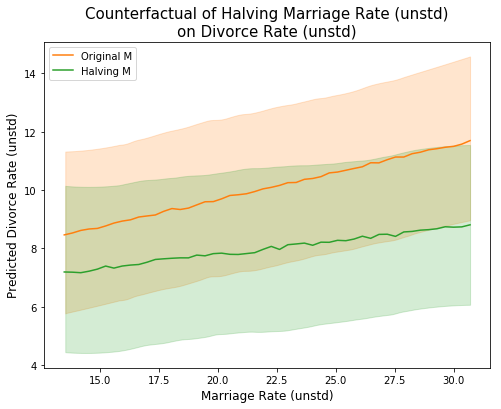

In [250]:
x_labels = mar_seq * data.Marriage.std() + data.Marriage.mean()

plt.figure(figsize=(8,6))
plt.plot(x_labels, unscale_divorce_rate(ppc_m2_cf['pred_div_std'].mean(0)), label="Original M", color='C1')
plt.plot(x_labels, unscale_divorce_rate(ppc_m2_cf_by_half["pred_div_std"].mean(0)), label="Halving M", color='C2')
az.plot_hpd(x_labels, unscale_divorce_rate(ppc_m2_cf['pred_div_std']), color='C1', fill_kwargs={"alpha": 0.2})
az.plot_hpd(x_labels, unscale_divorce_rate(ppc_m2_cf_by_half['pred_div_std']), color='C2', fill_kwargs={"alpha": 0.2})
# plt.xticks(plt.xticks()[0], labels=np.round(np.linspace(data.Marriage.min(), data.Marriage.max(), n), 1))
plt.legend(fontsize=10)
plt.xlabel("Marriage Rate (unstd)")
plt.ylabel("Predicted Divorce Rate (unstd)")
plt.title("Counterfactual of Halving Marriage Rate (unstd)\non Divorce Rate (unstd)", fontsize=15)

Text(0.5, 1.0, 'Counterfactual of Halving Marriage Rate (unstd)\non Median Age(unstd)')

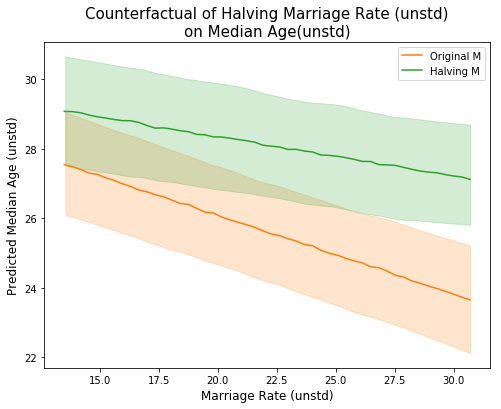

In [269]:
x_labels = mar_seq * data.Marriage.std() + data.Marriage.mean()

plt.figure(figsize=(8,6))
plt.plot(x_labels, unscale_age(ppc_m2_cf['pred_age_std'].mean(0)), label="Original M", color='C1')
plt.plot(x_labels, unscale_age(ppc_m2_cf_by_half["pred_age_std"].mean(0)), label="Halving M", color='C2')
az.plot_hpd(x_labels, unscale_age(ppc_m2_cf['pred_age_std']), color='C1', fill_kwargs={"alpha": 0.2})
az.plot_hpd(x_labels, unscale_age(ppc_m2_cf_by_half['pred_age_std']), color='C2', fill_kwargs={"alpha": 0.2})
# plt.xticks(plt.xticks()[0], labels=np.round(np.linspace(data.Marriage.min(), data.Marriage.max(), n), 1))
plt.legend(fontsize=10)
plt.xlabel("Marriage Rate (unstd)")
plt.ylabel("Predicted Median Age (unstd)")
plt.title("Counterfactual of Halving Marriage Rate (unstd)\non Median Age(unstd)", fontsize=15)

In [259]:
avg_orig_div = unscale_divorce_rate(ppc_m2_cf['pred_div_std'].mean(0))
avg_cf_div = unscale_divorce_rate(ppc_m2_cf_by_half['pred_div_std'].mean(0))

In [262]:
print(f"Avg divorce rate is {avg_orig_div.mean():.1f}%; If halving marriage rate, avg counterfactual divorce rate is {avg_cf_div.mean():.1f}%")
print(f"When halving marriage rate and all else kept equal, divorce rate is expected to drop relatively by {np.mean(1-avg_cf_div/avg_orig_div)*100:.1f}%")

Avg divorce rate is 10.1%; If halving marriage rate, avg counterfactual divorce rate is 8.0%
When halving marriage rate and all else kept equal, divorce rate is expected to drop relatively by 20.4%


#### 5H3.
**Q**: Return to the milk energy model. Suppose that the true causal relationship among the variables is: M -> K <- N, M -> N. Now compute the counterfactual effect on K of doubling M. You need to account for both the direct and indirect paths of causation.

**A**:   When doubling M and all else equal, milk is expected to contain 0.02 less kcal per gram.

In [7]:
data_milk = (pd.read_csv(os.path.join("/Users/huishi/Learning_DS/pymc3_resources/Rethinking_2/Data", "milk.csv"), 
                   delimiter=";")
            .rename(mapper=lambda x: x.replace('.', '_'), axis=1)
            .loc[lambda df: ~df.isnull().any(axis=1),:]
            )

data_milk['kcal_std'] = standardize(data_milk.kcal_per_g)
data_milk['neo_std'] = standardize(data_milk.neocortex_perc)
data_milk['mass_std'] = standardize(np.log(data_milk.mass))

unscale_kcal = lambda x: unstandadize(x, data_milk.kcal_per_g)
unscale_neo = lambda x: unstandadize(x, data_milk.neocortex_perc)
unscale_mass = lambda x: unstandadize(x, np.log(data_milk.mass))

In [8]:
with pm.Model() as m3:
    # data
    mass_std = pm.Data("mass_std", data_milk.mass_std)
    neo_std = pm.Data("neo_std", data_milk.neo_std)
    kcal_std = pm.Data("kcal_std", data_milk.kcal_std)
    
    ## M -> N
    # prior
    a_N = pm.Normal("a_N", 0, 0.2)
    b_MN = pm.Normal("b_MN", 0, 0.5)
    sigma_N = pm.Exponential("sigma_N", lam=1)
    
    # regression
    mu_N = pm.Deterministic("mu_N", a_N + b_MN * mass_std)
    pred_neo_std = pm.Normal("pred_neo_std", mu_N, sigma_N, observed=neo_std)
    
    ## M -> K <- N
    # prior
    a_K = pm.Normal("a_K", 0, 0.2)
    b_MK = pm.Normal("b_MK", 0, 0.5)
    b_NK = pm.Normal("b_NK", 0, 0.5)
    sigma_K = pm.Exponential("sigma_K", lam=1)
    
    # regression + likelihood
    mu_K = pm.Deterministic("mu_K", a_K + b_MK * mass_std + b_NK * neo_std)
    pred_kcal_std = pm.Normal("pred_kcal_std", mu_K, sigma_K, observed=kcal_std)
          
    # samples
    trace_m3 = pm.sample() 
    ppc_m3 = pm.sample_posterior_predictive(trace_m3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_K, b_NK, b_MK, a_K, sigma_N, b_MN, a_N]
100%|██████████| 2000/2000 [00:34<00:00, 57.85it/s]


In [9]:
az.summary(trace_m3, var_names=["~mu_N", "~mu_K"], kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
a_N,0.003,0.135,-0.219,0.209
b_MN,0.657,0.166,0.398,0.921
a_K,0.002,0.137,-0.205,0.229
b_MK,-0.659,0.278,-1.096,-0.223
b_NK,0.567,0.276,0.127,0.999
sigma_N,0.716,0.140,0.506,0.907
sigma_K,0.813,0.171,0.557,1.057


`pm.sample_posterior_predictive` only allows new data input with the same shape as the original data input. `len(data_milk)` is 17, but I want more granularity to n = 50.  I need to simulate the stats myself then. 

In [15]:
with m3:
    pm.set_data({"mass_std": mass_seq_std})
    ppc_neo = pm.sample_posterior_predictive(trace_m3, 1000, )
#     pm.set_data("neo_std": neo)

/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: Input dimension mis-match. (input[2].shape[0] = 50, input[4].shape[0] = 17)
Apply node that caused the error: Elemwise{Composite{(i0 + (i1 * i2) + (i3 * i4))}}(InplaceDimShuffle{x}.0, InplaceDimShuffle{x}.0, mass_std, InplaceDimShuffle{x}.0, neo_std)
Toposort index: 3
Inputs types: [TensorType(float64, (True,)), TensorType(float64, (True,)), TensorType(float64, vector), TensorType(float64, (True,)), TensorType(float64, vector)]
Inputs shapes: [(1,), (1,), (50,), (1,), (17,)]
Inputs strides: [(8,), (8,), (8,), (8,), (8,)]
Inputs values: [array([0.20037813]), array([-0.56337676]), 'not shown', array([0.36421925]), 'not shown']
Outputs clients: [['output']]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [6]:
n = 50
mass_seq = np.linspace(0.1, 80, n)
mass_seq_std = standardize(np.log(mass_seq), baseline=np.log(data_milk['mass']))
mass_seq_std_double = standardize(np.log(mass_seq*2), baseline=np.log(data_milk['mass']))

def simulate_ppc(trace, x_seq):
    sim_neo = stats.norm.rvs(loc = trace["a_N"] + trace["b_MN"] * x_seq.reshape(-1,1), scale = trace["sigma_N"])
    sim_kcal = stats.norm.rvs(loc = trace["a_K"] + trace["b_MK"] * x_seq.reshape(-1,1) + trace["b_NK"] * sim_neo, 
                             scale = trace["sigma_K"])
    return sim_neo, sim_kcal
    
cf_ppc = dict()
cf_ppc['neo'], cf_ppc['kcal'] = simulate_ppc(trace_m3, mass_seq_std)
cf_ppc['neo_2'], cf_ppc['kcal_2'] = simulate_ppc(trace_m3, mass_seq_std_double)

NameError: name 'trace_m3' is not defined

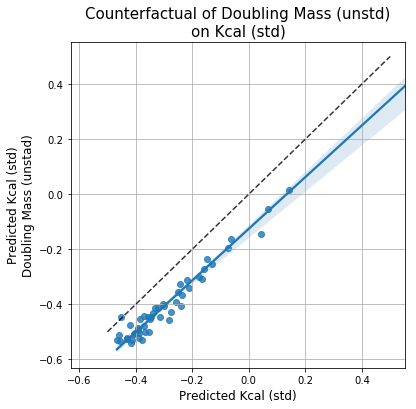

In [355]:
plt.figure(figsize=(6,6))
sns.regplot(cf_ppc['kcal'].mean(1), cf_ppc["kcal_2"].mean(1))
plt.plot([-0.5, 0.5], [-0.5,0.5], 'k--', alpha=0.8)
plt.xlim(plt.ylim())
plt.xlabel("Predicted Kcal (std)")
plt.ylabel("Predicted Kcal (std)\nDoubling Mass (unstad)")
plt.title("Counterfactual of Doubling Mass (unstd)\non Kcal (std)", fontsize=15)
plt.grid(True)

Text(0.5, 1.0, 'Counterfactual of Doubling Mass (unstd)\non Kcal (unstd)')

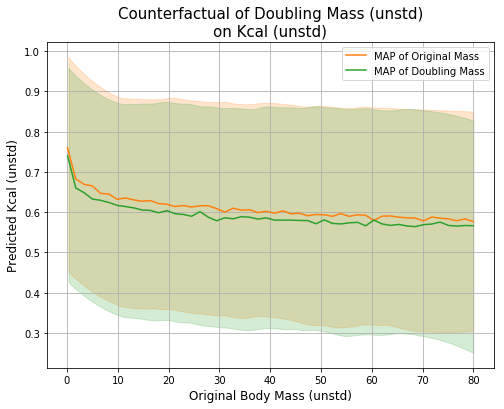

In [358]:
plt.figure(figsize=(8,6))
plt.plot(mass_seq, unscale_kcal(cf_ppc['kcal'].mean(1)), label="MAP of Original Mass", color='C1')
plt.plot(mass_seq, unscale_kcal(cf_ppc['kcal_2'].mean(1)), label="MAP of Doubling Mass", color='C2')
az.plot_hpd(mass_seq, unscale_kcal(cf_ppc['kcal'].T), color='C1', fill_kwargs={"alpha": 0.2})
az.plot_hpd(mass_seq, unscale_kcal(cf_ppc['kcal_2'].T), color='C2', fill_kwargs={"alpha": 0.2})
plt.legend(fontsize=10)
plt.xlabel("Original Body Mass (unstd)")
plt.ylabel("Predicted Kcal (unstd)")
plt.grid(True)
plt.title("Counterfactual of Doubling Mass (unstd)\non Kcal (unstd)", fontsize=15)

Difference in Kcal before and after doubling Mass

In [367]:
np.quantile(unscale_kcal(cf_ppc['kcal']).mean(1) - unscale_kcal(cf_ppc["kcal_2"]).mean(1), q=[0, 0.5, 1])

array([-0.00096067,  0.01823923,  0.03268838])

In [366]:
np.mean(unscale_kcal(cf_ppc['kcal']).mean(1) - unscale_kcal(cf_ppc["kcal_2"]).mean(1))

0.01876541378706368

#### 5H4.
**Q**: Add the South indicator in the divorce data. First, draw one or more GADs to repersent your ideas for houw Southern Amercian culture may influecne any of the other three variables. List testable implications if any and fit one or more models to evaluate the implications. 

**A**:  
Checked model 1. S -> D <- A, S -> A. S->A's HPD overlaps with 0.   
Checked model 2. S -> D <- A. When age_std = 0 (age is at the avg), being in the south increases divorce rate (unstd) by 0.9 (absolute %). 

In [369]:
southern_states = "Alabama, Arkansas, Delaware, Florida, Georgia, Kentucky, Louisiana, Maryland, Mississippi, North Carolina, Oklahoma, South Carolina, Tennessee, Texas, Virginia, West Virginia".split(", ")
data['in_south'] = data.Location.apply(lambda x: x in southern_states).astype(int)
assert len(southern_states) == data["in_south"].sum()

In [402]:
with pm.Model() as m4:
    # data
    age_std = pm.Data("age_std", data.medage_std)
    in_south = pm.Data('in_south', data.in_south)
    div_std = pm.Data('div_std', data.divorce_rate_std)
    
#     # prior for age
#     aA = pm.Normal("aA", 0, 0.2)
#     bDA = pm.Normal("bDA", 0, 0.5)
#     sigma_A = pm.Exponential("sigma_A", lam=1)
    
#     # regression for age
#     mu_age = pm.Deterministic("mu_age", aA + bDA * in_south)
#     pred_age_std = pm.Normal("pred_age_std", mu_age, sigma_A, observed=age_std)
    
    # prior for div
    a = pm.Normal('a', mu=0, sigma=0.2)
    bA = pm.Normal('bA', mu=0, sigma=0.5)
    bS = pm.Normal('bS', mu=0, sigma=0.5, shape=2)
    sigma = pm.Exponential('sigma', lam=1)
    
    # regression + likelihood
    mu = pm.Deterministic("mu", a + bA * age_std + bS[data.in_south])
    pred_div_std = pm.Normal('pred_div_std', mu=mu, sigma=sigma, observed=div_std)
    
    # samples
    trace_m4 = pm.sample() 
    ppc_m4 = pm.sample_posterior_predictive(trace_m4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bS, bA, a]
100%|██████████| 2000/2000 [00:18<00:00, 108.32it/s]


In [403]:
az.summary(trace_m4, var_names=["~mu", "~mu_age"], kind="stats")

,mean,sd,hpd_5.5%,hpd_94.5%
a,0.026,0.173,-0.251,0.304
bA,-0.523,0.114,-0.698,-0.338
bS[0],-0.186,0.205,-0.509,0.133
bS[1],0.295,0.244,-0.133,0.647
sigma,0.790,0.082,0.654,0.905


array([<matplotlib.axes._subplots.AxesSubplot object at 0x13af76e10>],
      dtype=object)

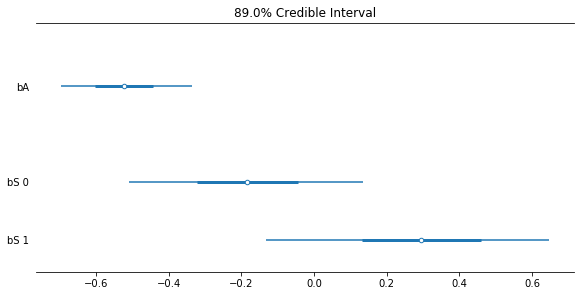

In [404]:
az.plot_forest(trace_m4, var_names=["bA", "bS"], combined=True, figsize=(8,4))

In [385]:
age_std = 0
mu_div_north = trace_m4['a'] + trace_m4["bS"][:,0]
mu_div_south = trace_m4['a'] + trace_m4["bS"][:,1]

In [389]:
unscale_divorce_rate(mu_div_north).mean(), unscale_divorce_rate(mu_div_south).mean()

(9.388053748681351, 10.290160625230415)

In [393]:
unscale_divorce_rate(az.hpd(mu_div_north)), unscale_divorce_rate(az.hpd(mu_div_south))

(array([8.98261475, 9.75191414]), array([ 9.75650613, 10.85846812]))